#Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Assignment/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Assignment


#Capturing necessary installation

In [2]:
!pip install albumentations
!pip install torchsummary
!pip install torch-lr-finder
!pip install torch-lr-finder -v --global-option="amp"

     |████████████████████████████████| 634kB 12.5MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=d88fcace1b404cf965d47e155df79976eee7c0a1ea7eae1c8575f5abc6274b9a
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-wwi2336o
Created temporary directory: /tmp/pip-req-tracker-jrgq9d22
Created requirements tracker '/tmp/pip-req-tracker-jrgq9d22'
Created temporary directory: /tmp/pip-install-qhvolv8r
Cleaning up...
Removed build tracker '/tmp/pip-req-tracker

#Applying transformations
For training we used horizontal flip, normalization and cutout



In [3]:
from Transform_utils.transforme_album import Data

data = Data()
trainset = data.getTrainDataSet(train=True)
testset =  data.getTrainDataSet(train=False)
trainloader = data.getDataLoader(trainset, 512)
trainloader1 = data.getDataLoader(trainset, 4)
testloader = data.getDataLoader(testset, 512)
testloader1 = data.getDataLoader(testset, 4)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#Images display post augmentation



  pip install torch-lr-finder -v --global-option="amp"


      plane        dog       deer       deer


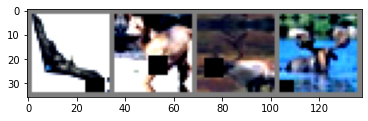

In [4]:
import torchvision
import general_utils

# get some random training images
dataiter = iter(trainloader1)
images, labels = dataiter.next()

# show images
general_utils.imshow(torchvision.utils.make_grid(images))
print('     ','      '.join('%5s' % classes[labels[j]] for j in range(4)))

#Importing torch Summary

In [5]:
from Model_ import S11_resnet as res
from torchsummary import summary
import cudas
import torch

device = torch.device("cuda" if cudas.cuda else "cpu")
net = res.Net().to(device)
summary(net, input_size=(3, 32, 32))

CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
        Dropout2d-13          [-1, 128, 16, 16]               0
           Conv2d-

/content/gdrive/My Drive/Assignment/Model_/S11_resnet.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


#Define a Loss function, optimizer
#Get LR finder results
Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from torch_lr_finder import LRFinder
import torch.optim as optim
import torch.nn as nn

def lrfinder(net, optimizer, criterion, trainloader, valloader):
  lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
  #lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
  lr_finder.range_test(trainloader, val_loader=valloader, end_lr=1, num_iter=100, step_mode="exp")
  lr_finder.plot() # to inspect the loss-learning rate graph
  lr_finder.reset() # to reset the model and optimizer to their initial state


/content/gdrive/My Drive/Assignment/Model_/S11_resnet.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)



Learning rate search finished. See the graph with {finder_name}.plot()


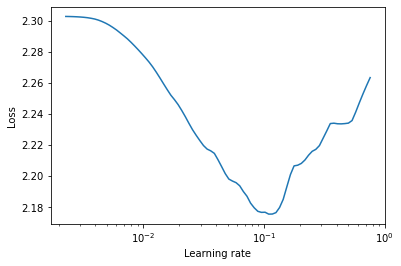

In [7]:
import general_utils as gu
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0001)
lrfinder(net, optimizer, criterion, trainloader, testloader)

#Set training params to find max LR

In [0]:
net = res.Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=5e-3, momentum=0.81, weight_decay=0.0085)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.2)

#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.02, max_lr=0.05, step_size_up=5/24, step_size_down=20/24, mode='triangular')
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

#Keep increasing learning rate with epoch to figure out max LR

In [9]:
import torch
from tqdm import tqdm
from Train_Test_utils.traine import train
from Train_Test_utils.teste import test
test_acc = []
train_acc = []
trainloss_ = []
testloss_ = []
lr_ = []
loss=1000
loss1= 1000
for epoch in range(20):  # loop over the dataset multiple times
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
      lr_.append(param_group['lr'])
    trainacc, loss = train(net, device, trainloader, optimizer, criterion, epoch)
    train_acc.append(trainacc)
    testacc, loss1 = test(net, device, testloader, criterion)
    test_acc.append(testacc)
    trainloss_.append(loss)
    testloss_.append(loss1)
    scheduler.step()
print('Finished Training')

  0%|          | 0/98 [00:00<?, ?it/s]

lr=  0.005


/content/gdrive/My Drive/Assignment/Model_/S11_resnet.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
Epoch= 0 Loss=2.1081604957580566 Batch_id=97 Accuracy=37.80: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.1300795 Test Accuracy= 36.77
lr=  0.006


Epoch= 1 Loss=2.0489227771759033 Batch_id=97 Accuracy=41.67: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.0038188 Test Accuracy= 44.48
lr=  0.0072


Epoch= 2 Loss=1.9736438989639282 Batch_id=97 Accuracy=51.49: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9736644 Test Accuracy= 48.59
lr=  0.00864


Epoch= 3 Loss=1.8596173524856567 Batch_id=97 Accuracy=66.96: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9207944 Test Accuracy= 56.72
lr=  0.010368


Epoch= 4 Loss=1.8244181871414185 Batch_id=97 Accuracy=67.56: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8561566 Test Accuracy= 62.13
lr=  0.0124416


Epoch= 5 Loss=1.827689528465271 Batch_id=97 Accuracy=68.45: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8214331 Test Accuracy= 64.68
lr=  0.01492992


Epoch= 6 Loss=1.7996289730072021 Batch_id=97 Accuracy=74.11: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8259935 Test Accuracy= 65.77
lr=  0.017915904


Epoch= 7 Loss=1.7372376918792725 Batch_id=97 Accuracy=77.98: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7930856 Test Accuracy= 69.66
lr=  0.0214990848


Epoch= 8 Loss=1.753169298171997 Batch_id=97 Accuracy=79.17: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7114779 Test Accuracy= 72.55
lr=  0.025798901759999996


Epoch= 9 Loss=1.716670036315918 Batch_id=97 Accuracy=80.36: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6919736 Test Accuracy= 72.97
lr=  0.030958682111999994


Epoch= 10 Loss=1.724313497543335 Batch_id=97 Accuracy=81.85: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.710214 Test Accuracy= 75.28
lr=  0.037150418534399994


Epoch= 11 Loss=1.6956679821014404 Batch_id=97 Accuracy=83.63: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7556922 Test Accuracy= 71.93
lr=  0.04458050224127999


Epoch= 12 Loss=1.6863749027252197 Batch_id=97 Accuracy=87.20: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7152722 Test Accuracy= 76.42
lr=  0.05349660268953599


Epoch= 13 Loss=1.7045305967330933 Batch_id=97 Accuracy=84.82: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7018242 Test Accuracy= 78.25
lr=  0.06419592322744318


Epoch= 14 Loss=1.6933461427688599 Batch_id=97 Accuracy=87.50: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7242669 Test Accuracy= 77.49
lr=  0.07703510787293182


Epoch= 15 Loss=1.7064447402954102 Batch_id=97 Accuracy=86.31: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7561991 Test Accuracy= 73.24
lr=  0.09244212944751817


Epoch= 16 Loss=1.7053781747817993 Batch_id=97 Accuracy=88.99: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.77705 Test Accuracy= 68.64
lr=  0.1109305553370218


Epoch= 17 Loss=1.7238225936889648 Batch_id=97 Accuracy=85.42: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8139839 Test Accuracy= 69.12
lr=  0.13311666640442615


Epoch= 18 Loss=1.7288068532943726 Batch_id=97 Accuracy=84.52: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8180146 Test Accuracy= 72.38
lr=  0.15973999968531138


Epoch= 19 Loss=1.7575517892837524 Batch_id=97 Accuracy=83.33: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
100%|██████████| 20/20 [00:03<00:00,  5.53it/s]

Test Loss= 1.8342173 Test Accuracy= 63.94
Finished Training


#Accuracy vs LR plot as mentioned in lecture

Text(0, 0.5, 'Accuracy')

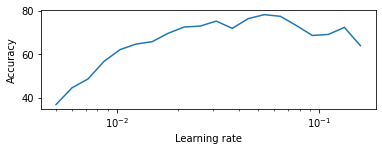

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(lr_, test_acc)
ax.set_xscale('log')
ax.set_xlabel("Learning rate")
ax.set_ylabel("Accuracy")

#Training the classifier with maxlr obtained above

In [0]:
net = res.Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.81, weight_decay=0.0085)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0025, max_lr=0.055, step_size_up=5, step_size_down=19, mode='triangular2')

In [12]:
import torch
from tqdm import tqdm
from Train_Test_utils.traine import train
from Train_Test_utils.teste import test
test_acc = []
train_acc = []
trainloss_ = []
testloss_ = []
lr_ = []
loss=1000
loss1= 1000
prev_loss1=1000
nn.Dropout2d
for epoch in range(25):  # loop over the dataset multiple times
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
      lr_.append(param_group['lr'])
    trainacc, loss = train(net, device, trainloader, optimizer, criterion, epoch)
    train_acc.append(trainacc)
    testacc, loss1 = test(net, device, testloader, criterion)
    test_acc.append(testacc)
    trainloss_.append(loss)
    testloss_.append(loss1)
    scheduler.step()
print('Finished Training')

  0%|          | 0/98 [00:00<?, ?it/s]

lr=  0.0025


/content/gdrive/My Drive/Assignment/Model_/S11_resnet.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
Epoch= 0 Loss=2.1483681201934814 Batch_id=97 Accuracy=28.57: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.157087 Test Accuracy= 32.46
lr=  0.013000000000000018


Epoch= 1 Loss=2.0530219078063965 Batch_id=97 Accuracy=41.96: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.0376225 Test Accuracy= 42.67
lr=  0.02349999999999998


Epoch= 2 Loss=1.9736043214797974 Batch_id=97 Accuracy=54.76: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9521433 Test Accuracy= 46.11
lr=  0.034


Epoch= 3 Loss=1.9546056985855103 Batch_id=97 Accuracy=55.65: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9760325 Test Accuracy= 49.19
lr=  0.04450000000000001


Epoch= 4 Loss=1.8679840564727783 Batch_id=97 Accuracy=65.77: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9452373 Test Accuracy= 53.4
lr=  0.05499999999999998


Epoch= 5 Loss=1.8698875904083252 Batch_id=97 Accuracy=66.96: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8816224 Test Accuracy= 58.73
lr=  0.05223684210526316


Epoch= 6 Loss=1.7795064449310303 Batch_id=97 Accuracy=76.49: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8174655 Test Accuracy= 65.62
lr=  0.04947368421052631


Epoch= 7 Loss=1.7387175559997559 Batch_id=97 Accuracy=82.14: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7696491 Test Accuracy= 75.86
lr=  0.04671052631578948


Epoch= 8 Loss=1.6823883056640625 Batch_id=97 Accuracy=86.90: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7797757 Test Accuracy= 71.74
lr=  0.04394736842105263


Epoch= 9 Loss=1.6964166164398193 Batch_id=97 Accuracy=85.71: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.713079 Test Accuracy= 77.37
lr=  0.04118421052631579


Epoch= 10 Loss=1.6923155784606934 Batch_id=97 Accuracy=84.23: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7958575 Test Accuracy= 71.2
lr=  0.03842105263157895


Epoch= 11 Loss=1.693864345550537 Batch_id=97 Accuracy=86.01: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6480495 Test Accuracy= 80.29
lr=  0.03565789473684211


Epoch= 12 Loss=1.6488487720489502 Batch_id=97 Accuracy=89.88: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7106081 Test Accuracy= 80.34
lr=  0.032894736842105275


Epoch= 13 Loss=1.6680079698562622 Batch_id=97 Accuracy=87.50: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7509894 Test Accuracy= 79.17
lr=  0.030131578947368412


Epoch= 14 Loss=1.6337734460830688 Batch_id=97 Accuracy=91.96: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.702321 Test Accuracy= 79.51
lr=  0.027368421052631577


Epoch= 15 Loss=1.6305732727050781 Batch_id=97 Accuracy=91.67: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6748339 Test Accuracy= 81.2
lr=  0.024605263157894745


Epoch= 16 Loss=1.6503695249557495 Batch_id=97 Accuracy=88.10: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7087861 Test Accuracy= 83.34
lr=  0.02184210526315788


Epoch= 17 Loss=1.626828670501709 Batch_id=97 Accuracy=91.07: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6950294 Test Accuracy= 82.91
lr=  0.019078947368421053


Epoch= 18 Loss=1.646131992340088 Batch_id=97 Accuracy=91.07: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6279298 Test Accuracy= 85.33
lr=  0.01631578947368422


Epoch= 19 Loss=1.6214673519134521 Batch_id=97 Accuracy=90.48: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6537223 Test Accuracy= 82.58
lr=  0.01355263157894736


Epoch= 20 Loss=1.5924828052520752 Batch_id=97 Accuracy=95.54: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6505415 Test Accuracy= 85.48
lr=  0.010789473684210528


Epoch= 21 Loss=1.609815001487732 Batch_id=97 Accuracy=92.26: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.5975527 Test Accuracy= 87.69
lr=  0.008026315789473694


Epoch= 22 Loss=1.5805071592330933 Batch_id=97 Accuracy=94.64: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6096015 Test Accuracy= 88.44
lr=  0.0052631578947368324


Epoch= 23 Loss=1.5574347972869873 Batch_id=97 Accuracy=94.64: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.5695109 Test Accuracy= 89.05
lr=  0.0025


Epoch= 24 Loss=1.5657685995101929 Batch_id=97 Accuracy=92.86: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
100%|██████████| 20/20 [00:03<00:00,  5.51it/s]

Test Loss= 1.5812193 Test Accuracy= 90.28
Finished Training


#Lr vs Epoch plot 

Text(0, 0.5, 'Epoch')

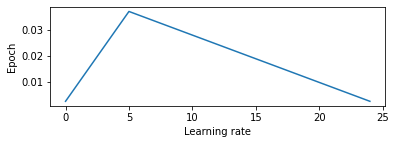

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(lr_)
ax.set_xlabel("Learning rate")
ax.set_ylabel("Epoch")

#Plot Train/Test Accuracy and loss

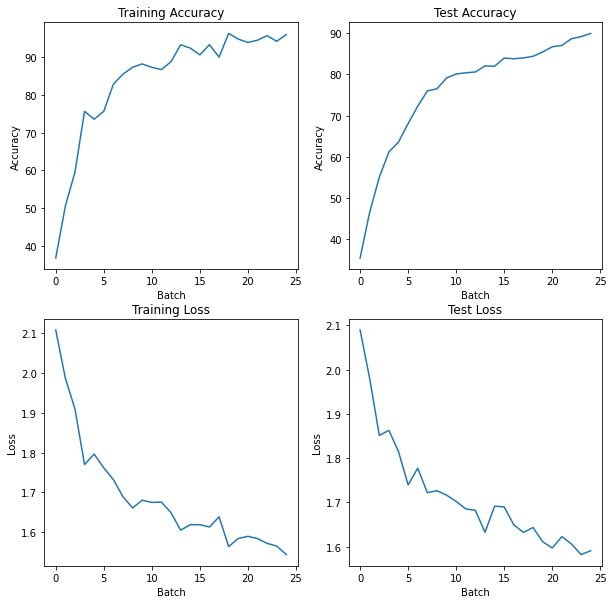

In [0]:
general_utils.plot_acc_loss(train_acc, test_acc, trainloss_, testloss_)

#Groundtruth vs Predictions

GT      dog       ship       deer        dog
Pred    dog       ship       deer        dog


/content/gdrive/My Drive/Assignment/Model_/S11_resnet.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


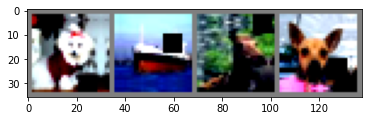

In [0]:
dataiter = iter(testloader1)
images, labels = dataiter.next()

# print images
general_utils.imshow(torchvision.utils.make_grid(images))
print('GT   ', '      '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Pred ', '      '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



#Categorywise predictions



In [0]:
from Train_Test_utils.teste import test_categorywise
test_categorywise(net, device, testloader, classes)

  0%|          | 0/20 [00:00<?, ?it/s]/content/gdrive/My Drive/Assignment/Model_/S11_resnet.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
100%|██████████| 20/20 [00:03<00:00,  6.08it/s]

Accuracy of plane : 80.00 %
Accuracy of   car : 100.00 %
Accuracy of  bird : 100.00 %
Accuracy of   cat : 100.00 %
Accuracy of  deer : 88.89 %
Accuracy of   dog : 57.14 %
Accuracy of  frog : 100.00 %
Accuracy of horse : 90.00 %
Accuracy of  ship : 100.00 %
Accuracy of truck : 100.00 %
